In [2]:
import pandas as pd
import numpy as np
import os
import cv2

# **Data Exploration**

In [3]:
data = pd.read_csv("../input/blood-cell-detection-dataset/annotations.csv")
data.head()

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc


# **Data Visualization**

Selected Images: ['image-8.png', 'image-104.png', 'image-102.png', 'image-79.png', 'image-4.png']
Image Path: ../input/blood-cell-detection-dataset/images/image-8.png
Image Path: ../input/blood-cell-detection-dataset/images/image-104.png
Image Path: ../input/blood-cell-detection-dataset/images/image-102.png
Image Path: ../input/blood-cell-detection-dataset/images/image-79.png
Image Path: ../input/blood-cell-detection-dataset/images/image-4.png


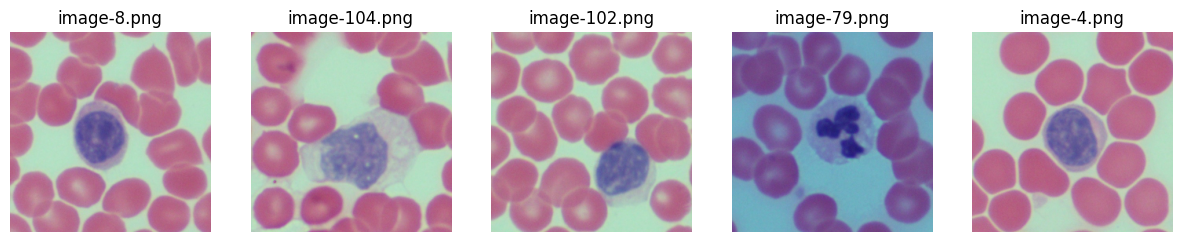

In [4]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

def visualize_images(dataset_path, num_images=5):
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]
    selected_images = random.sample(image_files, num_images)
    print("Selected Images:", selected_images)  # Diagnostic print statement
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(dataset_path, image_file)
        print("Image Path:", image_path)  # Diagnostic print statement
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_file)
    plt.show()

dataset_path = '../input/blood-cell-detection-dataset/images'
visualize_images(dataset_path, num_images=5)

# **Data Pre-Processing**

Image resizing

In [5]:
import os
from PIL import Image

def check_resize_needed(dataset_path, max_width=500, max_height=500):
    # Get a list of image file names in the dataset directory
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]

    # Iterate through each image and check if resizing is needed
    images_to_resize = []
    for image_file in image_files:
        image_path = os.path.join(dataset_path, image_file)
        image = Image.open(image_path)
        width, height = image.size
        if width > max_width or height > max_height:
            images_to_resize.append(image_file)

    if images_to_resize:
        print("Images needing resizing:")
        for image_file in images_to_resize:
            print(image_file)
    else:
        print("No images need resizing.")

# Specify the path to your dataset directory
dataset_path = '../input/blood-cell-detection-dataset/images'

# Set maximum dimensions for images
max_width = 500
max_height = 500

# Check if images need resizing
check_resize_needed(dataset_path, max_width, max_height)

No images need resizing.


Normalizing Images

In [6]:
import os
import numpy as np
from PIL import Image

def normalize_images(dataset_path, output_path):
    # Get a list of image file names in the dataset directory
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]

    # Iterate through each image and normalize pixel values
    for image_file in image_files:
        image_path = os.path.join(dataset_path, image_file)
        image = Image.open(image_path)

        # Convert image to numpy array and normalize pixel values
        image_array = np.array(image)
        normalized_image_array = image_array / 255.0  # Scaling pixel values to range [0, 1]

        # Convert normalized pixel values back to image
        normalized_image = Image.fromarray((normalized_image_array * 255).astype(np.uint8))

        # Save normalized image to the output directory
        output_image_path = os.path.join(output_path, image_file)
        normalized_image.save(output_image_path)

dataset_path = '../input/blood-cell-detection-dataset/images'

output_path = '/kaggle/working/normalized_images'

os.makedirs(output_path, exist_ok=True)

normalize_images(dataset_path, output_path)

Selected Images: ['image-118.png', 'image-75.png', 'image-88.png', 'image-115.png', 'image-37.png']
Image Path: ../working/normalized_images/image-118.png
Image Path: ../working/normalized_images/image-75.png
Image Path: ../working/normalized_images/image-88.png
Image Path: ../working/normalized_images/image-115.png
Image Path: ../working/normalized_images/image-37.png


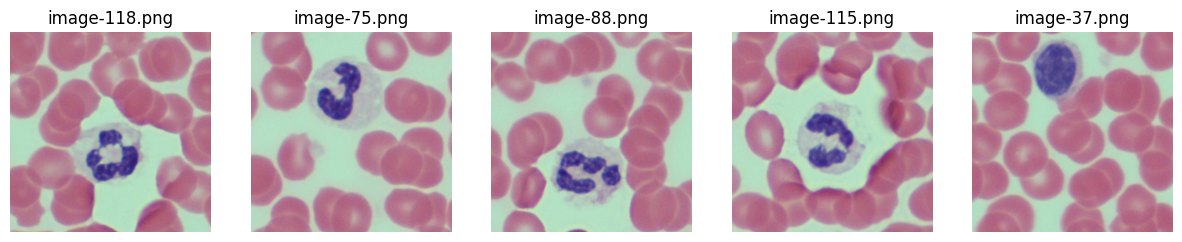

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

def visualize_images(dataset_path, num_images=5):
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.jpg') or f.endswith('.png')]
    selected_images = random.sample(image_files, num_images)
    print("Selected Images:", selected_images)  # Diagnostic print statement
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(dataset_path, image_file)
        print("Image Path:", image_path)  # Diagnostic print statement
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_file)
    plt.show()

dataset_path = '../working/normalized_images'
visualize_images(dataset_path, num_images=5)

# **Model Training**

In [8]:
import os
import torch
import pandas as pd
import PIL
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, target_path, class2idx, transforms = None):
        self.transforms = transforms
        self.files = os.listdir(img_path)
        self.df = pd.read_csv(target_path)
        self.df['label'] = self.df['label'].map(class2idx)
        
        self.imgs = []
        self.targets = []
        for i in range(len(self.files)):
            self.imgs.append(PIL.Image.open(os.path.join(img_path, self.files[i])).convert("RGB"))
        for i in range(len(self.files)):
            self.targets.append(self.df[self.df['image'] == self.files[i]])
            
    def __getitem__(self, i):
        target = {}
        target['boxes'] = torch.tensor(self.targets[i][['xmin', 'ymin', 'xmax', 'ymax']].values, dtype = torch.float32)
#         print(target['boxes'].shape, 'each images baxes')
        target['labels'] = torch.tensor(self.targets[i][['label']].values).reshape(-1)
#         img = torch.tensor(self.imgs[i]).permute(0, 3, 1, 2).float() / 255.0
        img = self.imgs[i]
        # Apply any transforms to the data if required.

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.files)
    
    
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target
class ToTensor(torch.nn.Module):
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
#             image = image.flip(-1)
            if target is not None:
                width, _ = F.get_image_size(image)
#                 target['boxes'].clone()
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
    
        if torch.rand(1) < self.p:
            image = F.vflip(image)
            if target is not None:
                _, h = F.get_image_size(image)
                target["boxes"][:, [1, 3]] = h - target["boxes"][:, [3, 1]]

        return image, target
def get_transform(train):
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)
    

class2idx = {'rbc':1, 'wbc':2}
img_path = '/kaggle/input/blood-cell-detection-dataset/images'
target_path = '/kaggle/input/blood-cell-detection-dataset/annotations.csv'

In [9]:
train_ds = CustomDataset(img_path, target_path, class2idx, get_transform(train = True))

val_ds = CustomDataset(img_path, target_path, class2idx, get_transform(train = False))

test_ds = CustomDataset(img_path, target_path, class2idx, get_transform(train = False))

indices = torch.randperm(len(train_ds)).tolist()
train_ds = torch.utils.data.Subset(train_ds,
           indices[:int(len(indices) * 0.64)])
val_ds = torch.utils.data.Subset(val_ds, 
         indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
test_ds = torch.utils.data.Subset(test_ds, 
          indices[int(len(indices) * 0.8):])

def collate_fn(batch):
    return tuple(zip(*batch))
train_dl = torch.utils.data.DataLoader(train_ds, 
                                 batch_size = 8, 
                                 shuffle = True, 
                        collate_fn = collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, 
                             batch_size = 8, 
                            shuffle = False, 
                    collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds, 
                               batch_size = 8, 
                              shuffle = False, 
                      collate_fn = collate_fn)

**SEGMENTATION**

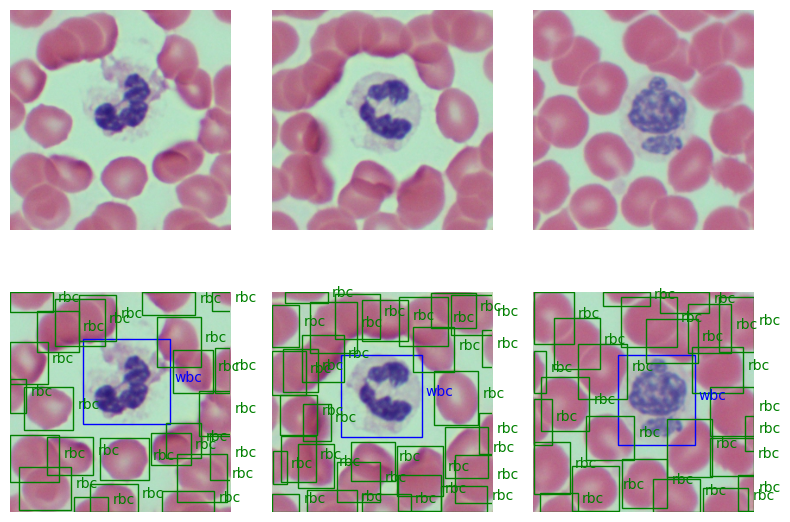

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

batch = next(iter(train_dl))
data, target = batch

label_colors = ['r', 'y'] 
gnd_colors = ['g', 'b']
image_names = [6, 7, 0]

fig, axs = plt.subplots(2, 3, figsize=(8, 6))

for i, image_name in enumerate(image_names):

    image = data[image_name].permute(1, 2, 0)

    selected = target[image_name]
    
    boxes = selected['boxes']
    boxes = torch.vstack((boxes[:, 0], boxes[:, 1], boxes[:, 2]-boxes[:, 0], boxes[:, 3]-boxes[:, 1])).T
    labels = selected['labels']
    
    ax = axs[0, i]
    ax.imshow(image)
    ax.axis('off')  
    
    ax = axs[1, i]
    ax.imshow(image)
    ax.axis('off')  
    
    for box, label in zip(boxes, labels):
        x, y, w, h = box
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=gnd_colors[label.item()-1], facecolor='none')
        ax.add_patch(rect)
        ax.text(x + w + 5, y + h // 2, list(class2idx.keys())[label.item()-1], fontsize=10, color=gnd_colors[label.item()-1])
    
plt.tight_layout()
plt.show()

In [11]:
def fastrcnn_loss_modified(class_logits, box_regression, labels, regression_targets):
    labels = torch.cat(labels, dim=0)
    regression_targets = torch.cat(regression_targets, dim=0)
    w = torch.Tensor([1.0, 1.0, 24.0])
    classification_loss = F.cross_entropy(class_logits, labels, w)
    sampled_pos_inds_subset = torch.where(labels > 0)[0]
    labels_pos = labels[sampled_pos_inds_subset]
    N, num_classes = class_logits.shape
    box_regression = box_regression.reshape(N, box_regression.size(-1) // 4, 4)
    box_loss = F.smooth_l1_loss(
        box_regression[sampled_pos_inds_subset, labels_pos],
        regression_targets[sampled_pos_inds_subset],
        beta=1 / 9,
        reduction="sum",
    )
    box_loss = box_loss / labels.numel()

    return classification_loss, box_loss

In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn_v2

def get_object_detection_model(num_classes = 3, 
                               feature_extraction = True):
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   num_classes)
    model.roi_heads.fastrcnn_loss = fastrcnn_loss_modified
    return model

In [13]:
def unbatch(batch, device):
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y

def train_batch(batch, model, optimizer, device):
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

def validate_batch(batch, model, optimizer, device):
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [14]:
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.0 MB/s eta 0:00:00a 0:00:01m
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 63.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.7 MB/s eta 0:00:00:00:01
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=d94b465b5d38a8f28f9f1d25568b5e96d33647bdc54a217116ef019cdfc37e67
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typin

In [15]:
from torch_snippets import Report
def train_fasterrcnn(model, 
                 optimizer, 
                  n_epochs, 
              train_loader, 
        test_loader = None, 
                log = None, 
               keys = None, 
            device = "cpu"):
    train_losses, val_losses = [], []
    trn_loss = 0
    trn_size = 0
    val_loss = 0
    val_size = 0
    
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier", 
                   "loss_box_reg", 
                "loss_objectness", 
               "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model, 
                                  optimizer, device)
            # Record the current train loss.
            pos = epoch + (ix + 1) / N
            log.record(pos = pos, trn_loss = loss.item(), 
                       end = "\r")
            trn_loss += loss.item()
            trn_size += len(batch)
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model, 
                                         optimizer, device)
                pos = epoch + (ix + 1) / N
                log.record(pos = pos, val_loss = loss.item(), 
                           end = "\r")
                val_loss += loss.item()
                val_size += len(batch)
                
        train_losses.append(trn_loss/trn_size)
        val_losses.append(val_loss/val_size)
    log.report_avgs(epoch + 1)
    return log, train_losses, val_losses

In [16]:
import time
device = 'cuda'
model = get_object_detection_model(num_classes = 3,   
                        feature_extraction = False)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                        lr = 0.005, 
                    momentum = 0.9, 
             weight_decay = 0.0005)
st = time.time()
log, t_loss, v_loss = train_fasterrcnn(model = model, 
               optimizer = optimizer, 
                        n_epochs = 17,
             train_loader = train_dl, 
                test_loader = val_dl,
             log = None, keys = None,
                     device = device)
et = time.time()
print(et - st)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 135MB/s]  


EPOCH: 17.000  val_loss: 0.375  trn_loss: 0.309  (233.73s - 0.00s remaining)
233.73502779006958


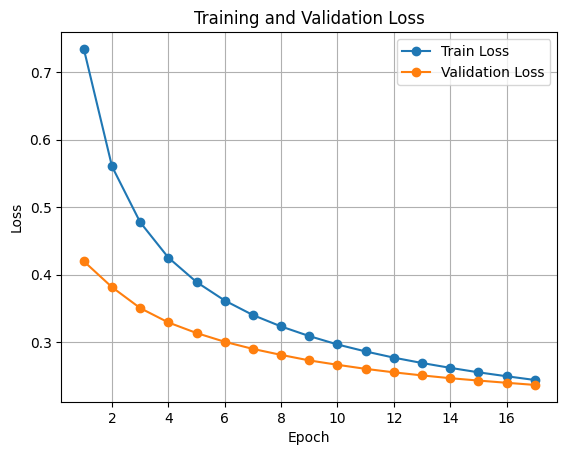

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(t_loss) + 1), t_loss, label='Train Loss', marker='o')
plt.plot(range(1, len(v_loss) + 1), v_loss, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [18]:
@torch.no_grad()
def predict_batch(batch, model, device):
    model.to(device)
    model.eval()
    X, ground_truth = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions, ground_truth
def predict(model, data_loader, device = "cpu"):
    gnd = []
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p, gd = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p
        gnd.extend(gd)
    
    return images, predictions, gnd

In [19]:
def decode_prediction(prediction, 
                      score_threshold = 0.8, 
                      nms_iou_threshold = 0.2):
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    if score_threshold is not None:
        want = scores > score_threshold
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores, 
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]
    return (boxes.cpu().numpy(), 
            labels.cpu().numpy(), 
            scores.cpu().numpy())

In [22]:
images, predictions, ground_truth = predict(model, test_dl, device)

In [23]:
import torch
from collections import Counter

import torch

def reformat_res(predictions, isThereScore):
    res = []
    for i in range(len(predictions)):
        idx = torch.zeros((len(predictions[i]['labels']), 1))
        idx.fill_(i)
        if isThereScore:
            scores = predictions[i]['scores'].reshape(-1, 1)
        else:
            scores = torch.ones(len(predictions[i]['labels']), 1)   
        
        res.append(torch.hstack((idx.cpu(), predictions[i]['labels'].reshape(-1, 1).cpu(),
                                     scores.cpu(), predictions[i]['boxes'].cpu())))
            
    res = torch.cat(res)
    return res
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=2
):

    average_precisions = []

    epsilon = 1e-6

    for c in range(1, num_classes+1):
        
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([int(gt[0].item()) for gt in ground_truths])
        
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
#             print(detection[0], len(ground_truth_img))
            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    detection[3:].clone(),
                    gt[3:].clone(),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[int(detection[0].item())][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[int(detection[0].item())][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        
        average_precisions.append(torch.trapz(precisions, recalls))

    arr = torch.stack(average_precisions).sum()
    return arr.item() / len(average_precisions)

formated_preds = reformat_res(predictions, True)
formated_gnd = reformat_res(ground_truth, False)
map5 = mean_average_precision(formated_preds, formated_gnd)
print('map@0.5 on test set', map5)

map@0.5 on test set 0.9952150583267212


# **Model Evaluation**

Number of predictions: 20
Number of ground truth annotations: 20
Number of images: 20


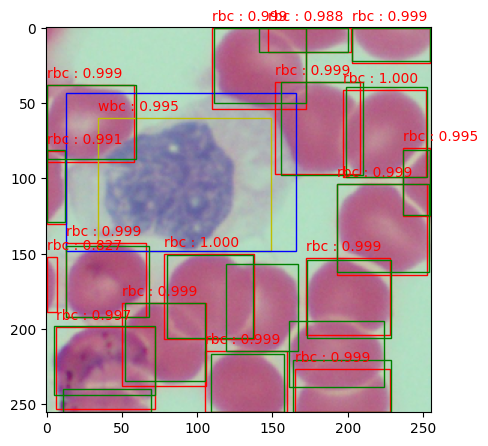

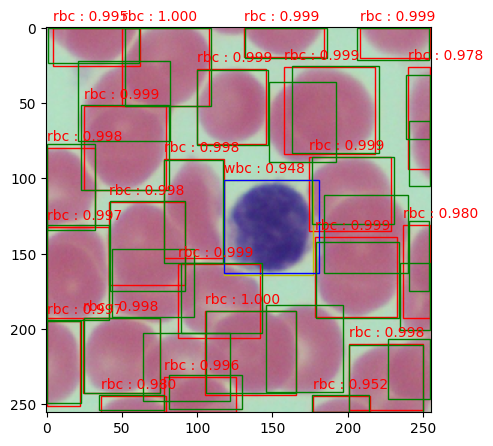

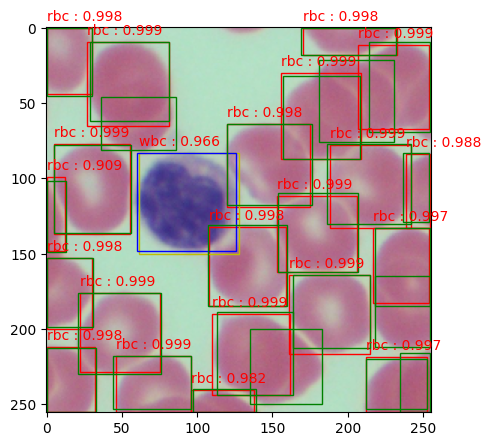

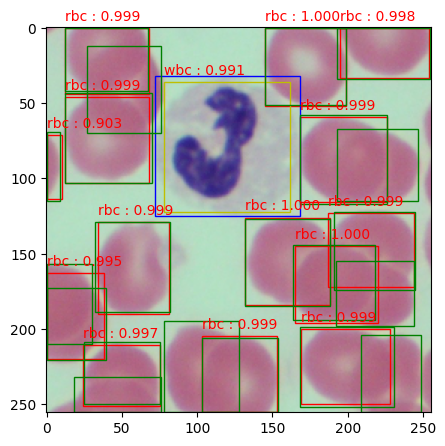

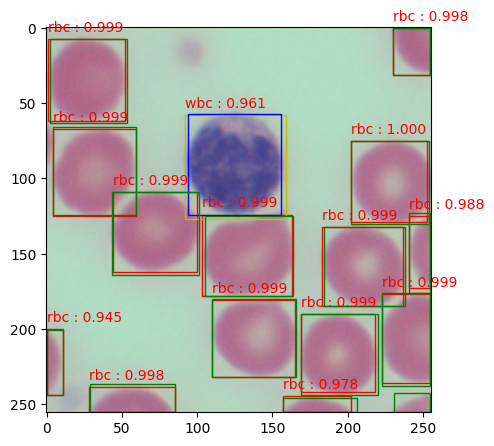

In [27]:
# Check lengths of the lists
num_predictions = len(predictions)
num_ground_truths = len(ground_truth)
num_images = len(images)

print(f"Number of predictions: {num_predictions}")
print(f"Number of ground truth annotations: {num_ground_truths}")
print(f"Number of images: {num_images}")

# Adjust indices based on the shortest list length
max_length = min(num_predictions, num_ground_truths, num_images)

# Example: Adding more indices to visualize more images within the valid range
indxs = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36]
indxs = [i for i in indxs if i < max_length]  # Ensure all indices are within the valid range

for img_index in indxs:
    boxes, labels, scores = decode_prediction(predictions[img_index])
    gnd_boxes = ground_truth[img_index]['boxes']
    gnd_labels = ground_truth[img_index]['labels']
    
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.imshow(images[img_index].permute(1, 2, 0).numpy())
    
    # Plot predicted boxes
    for i, b in enumerate(boxes):
        rect = patches.Rectangle(b[:2].astype(int),
                                 (b[2] - b[0]).astype(int),
                                 (b[3] - b[1]).astype(int),
                                 linewidth=1,
                                 edgecolor=label_colors[labels[i].item() - 1],
                                 facecolor="none")
        ax.add_patch(rect)
        ax.text(b[0].astype(int),
                b[1].astype(int) - 5,
                "{} : {:.3f}".format(list(class2idx.keys())[labels[i] - 1], scores[i]),
                color="r")
    
    # Plot ground truth boxes
    for i, b in enumerate(gnd_boxes):
        rect = patches.Rectangle(b[:2].detach().to(int).cpu(),
                                 (b[2] - b[0]).detach().to(int).cpu(),
                                 (b[3] - b[1]).detach().to(int).cpu(),
                                 linewidth=1,
                                 edgecolor=gnd_colors[gnd_labels[i].item() - 1],
                                 facecolor="none")
        ax.add_patch(rect)
    
    plt.show()